In [1]:
# 1️⃣ Clone repo về
!git clone https://github.com/Vietchemistryyy/Fake_News_Detection_BERT.git

# 2️⃣ Chuyển vào thư mục repo
%cd Fake_News_Detection_BERT

# 3️⃣ Kiểm tra thư mục src có tồn tại
!ls

Cloning into 'Fake_News_Detection_BERT'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 240 (delta 139), reused 154 (delta 67), pack-reused 0 (from 0)
Receiving objects: 100% (240/240), 8.12 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/Fake_News_Detection_BERT
data		      models	 README.md	   results  src
FakeNewDetection2025  notebooks  requirements.txt  scripts  tests


In [2]:
# CELL 1: Environment Test & Setup
# ============================================================================

print("="*80)
print("ENVIRONMENT SETUP & VERIFICATION")
print("="*80)

import os, sys
os.chdir("/content/Fake_News_Detection_BERT")  # Di chuyển vào thư mục gốc project
sys.path.append(os.getcwd())                   # Thêm đường dẫn hiện tại vào sys.path
print("📁 Working directory:", os.getcwd())
sys.path.append('..')

# Test basic imports
try:
    import transformers
    print(f"✅ Transformers version: {transformers.__version__}")

    from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
    print("✅ Core transformers imports successful")

    # Test tokenizer
    test_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    print("✅ Tokenizer test successful")

    # Import project modules
    from src.config import ModelConfig, DataConfig
    from src.train import TRANSFORMERS_AVAILABLE, EARLY_STOPPING_AVAILABLE

    print(f"✅ TRANSFORMERS_AVAILABLE: {TRANSFORMERS_AVAILABLE}")
    print(f"✅ EARLY_STOPPING_AVAILABLE: {EARLY_STOPPING_AVAILABLE}")
    print("\n🎉 Environment ready for training!")

except ImportError as e:
    print(f"❌ Import error: {e}")
    print("\n💡 Installing required packages...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                          'transformers', 'accelerate', 'datasets'])
    print("✅ Packages installed. Please restart kernel and run again.")
    raise


ENVIRONMENT SETUP & VERIFICATION
📁 Working directory: /content/Fake_News_Detection_BERT
✅ Transformers version: 4.57.1
✅ Core transformers imports successful


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer test successful
✅ Transformers 4.57.1 loaded successfully
✅ EarlyStoppingCallback available
✅ Fake News Detection package loaded successfully
✅ TRANSFORMERS_AVAILABLE: True
✅ EARLY_STOPPING_AVAILABLE: True

🎉 Environment ready for training!


# ============================================================================
# NOTEBOOK 04: BERT MODEL TRAINING
# ============================================================================

## 🎯 Objective
Fine-tune a BERT model for fake news detection and compare performance with the baseline model.

## 📋 What we'll do:
1. **Load preprocessed data** from notebook 02
2. **Prepare PyTorch datasets** for BERT training
3. **Fine-tune BERT model** using Hugging Face Transformers
4. **Evaluate performance** on train/val/test sets
5. **Compare with baseline** model performance
6. **Save model** and results

---


In [3]:
# CELL 2: Complete Imports
# ============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer

# Import project modules
from src.config import (
    DataConfig, ModelConfig, TrainingConfig,
    PROCESSED_DATA_DIR, METRICS_DIR, VISUALIZATIONS_DIR, MODELS_DIR
)
from src.dataset import create_dataset_from_dataframe
from src.train import BertTrainer, save_training_results
from src.evaluate import (
    compute_extended_metrics,
    plot_confusion_matrix,
    plot_roc_curve,
    compare_models,
    save_evaluation_results
)
from src.utils import save_json


device_name = "cpu"  # default fallback
device = torch.device("cpu")

try:
    # Try TPU
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    device_name = str(device)
except ImportError:
    # If no TPU, check GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name(0)
    else:
        device = torch.device("cpu")
        device_name = "CPU"


plt.style.use('default')
sns.set_palette("husl")


print("=" * 80)
print("IMPORTS COMPLETED")
print("=" * 80)
print(f"🖥️  Device: {device} ({device_name})")
print(f"🤖 Model: {ModelConfig.MODEL_NAME}")
print(f"📊 Ready to train!")
print("=" * 80)


IMPORTS COMPLETED
🖥️  Device: cuda (Tesla T4)
🤖 Model: roberta-base
📊 Ready to train!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Giả sử dữ liệu nằm ở:
# /content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/
import os

# Chuyển đường dẫn trong DataConfig
DataConfig.TRAIN_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/train.csv'
DataConfig.VAL_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/val.csv'
DataConfig.TEST_PATH = '/content/drive/MyDrive/Fake_News_Detection_BERT/data/processed/test.csv'

# Kiểm tra tồn tại
print(os.path.exists(DataConfig.TRAIN_PATH))

Mounted at /content/drive
True


In [5]:
# CELL 3: Load Data
# ============================================================================
print("="*80)
print("LOADING PREPROCESSED DATA")
print("="*80)

# Load datasets
train_df = pd.read_csv(DataConfig.TRAIN_PATH)
val_df = pd.read_csv(DataConfig.VAL_PATH)
test_df = pd.read_csv(DataConfig.TEST_PATH)

print(f"\n📊 Data loaded successfully:")
print(f"   Train: {train_df.shape[0]:>7,} samples")
print(f"   Val:   {val_df.shape[0]:>7,} samples")
print(f"   Test:  {test_df.shape[0]:>7,} samples")
print(f"   Total: {(train_df.shape[0] + val_df.shape[0] + test_df.shape[0]):>7,} samples")

# Check label distribution
print(f"\n📈 Label distribution:")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    fake_pct = (df['label'] == 1).sum() / len(df) * 100
    print(f"   {name:5} - Fake: {fake_pct:5.2f}%, Real: {100-fake_pct:5.2f}%")


LOADING PREPROCESSED DATA

📊 Data loaded successfully:
   Train:  95,244 samples
   Val:    20,409 samples
   Test:   20,410 samples
   Total: 136,063 samples

📈 Label distribution:
   Train - Fake: 46.90%, Real: 53.10%
   Val   - Fake: 46.90%, Real: 53.10%
   Test  - Fake: 46.90%, Real: 53.10%


In [6]:
# CELL 4: Load Tokenizer
# ============================================================================
print("="*80)
print("LOADING TOKENIZER")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(ModelConfig.MODEL_NAME)

print(f"\n🔤 Tokenizer: {ModelConfig.MODEL_NAME}")
print(f"   Vocab size: {tokenizer.vocab_size:,}")
print(f"   Max length: {ModelConfig.MAX_LENGTH}")
print(f"   Padding: {ModelConfig.PADDING}")
print(f"   Truncation: {ModelConfig.TRUNCATION}")

# Test tokenization
sample_text = train_df.iloc[0]['cleaned_content']
sample_tokens = tokenizer.encode(sample_text, max_length=ModelConfig.MAX_LENGTH, truncation=True)

print(f"\n🧪 Tokenization test:")
print(f"   Input length: {len(sample_text)} chars")
print(f"   Output length: {len(sample_tokens)} tokens")
print(f"   First 10 tokens: {sample_tokens[:10]}")


LOADING TOKENIZER


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


🔤 Tokenizer: roberta-base
   Vocab size: 50,265
   Max length: 256
   Padding: max_length
   Truncation: True

🧪 Tokenization test:
   Input length: 85 chars
   Output length: 26 tokens
   First 10 tokens: [0, 642, 718, 5992, 32, 6749, 154, 31, 821, 7043]


In [7]:
# CELL 5: Create PyTorch Datasets
# ============================================================================
print("="*80)
print("CREATING PYTORCH DATASETS")
print("="*80)

# Create datasets with proper error handling
try:
    train_dataset = create_dataset_from_dataframe(train_df, tokenizer)
    val_dataset = create_dataset_from_dataframe(val_df, tokenizer)
    test_dataset = create_dataset_from_dataframe(test_df, tokenizer)

    print(f"\n✅ Datasets created successfully:")
    print(f"   Train: {len(train_dataset):,} samples")
    print(f"   Val:   {len(val_dataset):,} samples")
    print(f"   Test:  {len(test_dataset):,} samples")

    # Verify dataset structure
    sample = train_dataset[0]
    print(f"\n🔍 Dataset structure:")
    print(f"   input_ids shape: {sample['input_ids'].shape}")
    print(f"   attention_mask shape: {sample['attention_mask'].shape}")
    print(f"   labels: {sample['labels'].item()}")

except Exception as e:
    print(f"❌ Error creating datasets: {e}")
    raise

CREATING PYTORCH DATASETS

✅ Datasets created successfully:
   Train: 95,244 samples
   Val:   20,409 samples
   Test:  20,410 samples

🔍 Dataset structure:
   input_ids shape: torch.Size([256])
   attention_mask shape: torch.Size([256])
   labels: 1


In [8]:
# CELL 6: Initialize Trainer
# ============================================================================
print("="*80)
print("INITIALIZING TRAINER")
print("="*80)

# Create output directory
output_dir = MODELS_DIR / "roberta"
output_dir.mkdir(parents=True, exist_ok=True)

# Initialize trainer
bert_trainer = BertTrainer(
    model_name=ModelConfig.MODEL_NAME,
    output_dir=str(output_dir)
)

print(f"✅ Trainer initialized:")
print(f"   Model: {ModelConfig.MODEL_NAME}")
print(f"   Output: {output_dir}")


INITIALIZING TRAINER
✅ Trainer initialized:
   Model: roberta-base
   Output: /content/Fake_News_Detection_BERT/models/roberta


In [9]:
# CELL 7: Train Model
# ============================================================================
print("="*80)
print("TRAINING MODEL")
print("="*80)

# Display training configuration
print(f"\n⚙️  Training Configuration:")
print(f"   Epochs: {ModelConfig.NUM_EPOCHS}")
print(f"   Batch size: {ModelConfig.BATCH_SIZE}")
print(f"   Learning rate: {ModelConfig.LEARNING_RATE}")
print(f"   Warmup steps: {ModelConfig.WARMUP_STEPS}")
print(f"   Weight decay: {ModelConfig.WEIGHT_DECAY}")
print(f"   Device: {device}")
print(f"   FP16: {TrainingConfig.USE_FP16 and torch.cuda.is_available()}")

# Train the model
print(f"\n🚀 Starting training...\n")

try:
    train_results = bert_trainer.train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=ModelConfig.NUM_EPOCHS,
        batch_size=ModelConfig.BATCH_SIZE,
        learning_rate=ModelConfig.LEARNING_RATE,
        warmup_steps=ModelConfig.WARMUP_STEPS,
        weight_decay=ModelConfig.WEIGHT_DECAY
    )

    print("\n✅ Training completed successfully!")

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    raise

# Display training summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"⏱️  Training time: {train_results['training_time']:.2f}s ({train_results['training_time']/60:.2f}m)")
print(f"\n📊 Final validation metrics:")
for k, v in train_results['eval_metrics'].items():
    if isinstance(v, (int, float)):
        print(f"   {k:20}: {v:.4f}")

TRAINING MODEL

⚙️  Training Configuration:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Warmup steps: 500
   Weight decay: 0.01
   Device: cuda
   FP16: True

🚀 Starting training...



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.112100,0.129766,0.920084,0.929667,0.920084,0.920024
2,0.129200,0.119590,0.923857,0.932234,0.923857,0.923115
3,0.097600,0.126875,0.922534,0.932584,0.922534,0.922465



✅ Training completed successfully!

TRAINING SUMMARY
⏱️  Training time: 4042.57s (67.38m)

📊 Final validation metrics:
   eval_loss           : 0.1196
   eval_accuracy       : 0.9239
   eval_precision      : 0.9322
   eval_recall         : 0.9239
   eval_f1             : 0.9231
   eval_runtime        : 77.5012
   eval_samples_per_second: 263.3380
   eval_steps_per_second: 16.4640
   epoch               : 3.0000


In [10]:
# CELL 8: Evaluate on Test Set
# ============================================================================
print("="*80)
print("TEST SET EVALUATION")
print("="*80)

try:
    # Evaluate
    test_results = bert_trainer.evaluate(test_dataset)

    print("\n✅ Test evaluation completed!")
    print(f"\n📊 Test metrics:")
    for k, v in test_results.items():
        if isinstance(v, (int, float)):
            print(f"   {k:20}: {v:.4f}")

except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    raise

TEST SET EVALUATION



✅ Test evaluation completed!

📊 Test metrics:
   eval_loss           : 0.1184
   eval_accuracy       : 0.9248
   eval_precision      : 0.9333
   eval_recall         : 0.9248
   eval_f1             : 0.9241
   eval_runtime        : 86.9858
   eval_samples_per_second: 234.6360
   eval_steps_per_second: 14.6690
   epoch               : 3.0000


In [11]:
# CELL 9: Get Detailed Predictions
# ============================================================================
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

try:
    # Get predictions
    predictions = bert_trainer.trainer.predict(test_dataset)

    # Extract predictions and probabilities
    y_test_pred = np.argmax(predictions.predictions, axis=1)
    y_test_proba = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    y_test_true = test_df['label'].values

    print(f"\n✅ Predictions generated:")
    print(f"   Samples: {len(y_test_true):,}")
    print(f"   Predictions shape: {y_test_pred.shape}")
    print(f"   Probabilities shape: {y_test_proba.shape}")

    # Prediction distribution
    unique, counts = np.unique(y_test_pred, return_counts=True)
    print(f"\n📊 Prediction distribution:")
    for label, count in zip(unique, counts):
        label_name = "Real" if label == 0 else "Fake"
        pct = count / len(y_test_pred) * 100
        print(f"   {label_name}: {count:>6,} ({pct:5.2f}%)")

    # True label distribution
    unique, counts = np.unique(y_test_true, return_counts=True)
    print(f"\n📊 True label distribution:")
    for label, count in zip(unique, counts):
        label_name = "Real" if label == 0 else "Fake"
        pct = count / len(y_test_true) * 100
        print(f"   {label_name}: {count:>6,} ({pct:5.2f}%)")

except Exception as e:
    print(f"❌ Failed to generate predictions: {e}")
    raise


GENERATING PREDICTIONS



✅ Predictions generated:
   Samples: 20,410
   Predictions shape: (20410,)
   Probabilities shape: (20410, 2)

📊 Prediction distribution:
   Real: 12,303 (60.28%)
   Fake:  8,107 (39.72%)

📊 True label distribution:
   Real: 10,837 (53.10%)
   Fake:  9,573 (46.90%)


In [12]:
# CELL 10: Compute Extended Metrics
# ============================================================================
print("="*80)
print("COMPUTING EXTENDED METRICS")
print("="*80)

try:
    # Compute comprehensive metrics
    roberta_evaluation = compute_extended_metrics(
        y_true=y_test_true,
        y_pred=y_test_pred,
        y_proba=y_test_proba
    )

    # Add model name
    roberta_evaluation['model_name'] = f"RoBERTa ({ModelConfig.MODEL_NAME})"

    print("\n✅ Extended metrics computed!")
    print(f"\n📊 Complete evaluation results:")
    print(f"   Accuracy:  {roberta_evaluation['accuracy']:.4f}")
    print(f"   Precision: {roberta_evaluation['precision']:.4f}")
    print(f"   Recall:    {roberta_evaluation['recall']:.4f}")
    print(f"   F1-score:  {roberta_evaluation['f1']:.4f}")
    if 'roc_auc' in roberta_evaluation:
        print(f"   ROC-AUC:   {roberta_evaluation['roc_auc']:.4f}")
    if 'average_precision' in roberta_evaluation:
        print(f"   Avg Precision: {roberta_evaluation['average_precision']:.4f}")

    # Print classification report
    from sklearn.metrics import classification_report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test_true, y_test_pred,
                                target_names=['Real', 'Fake'],
                                digits=4))

except Exception as e:
    print(f"❌ Failed to compute metrics: {e}")
    raise


COMPUTING EXTENDED METRICS

✅ Extended metrics computed!

📊 Complete evaluation results:
   Accuracy:  0.9248
   Precision: 0.9333
   Recall:    0.9248
   F1-score:  0.9241
   ROC-AUC:   0.9880
   Avg Precision: 0.9867

📋 Classification Report:
              precision    recall  f1-score   support

        Real     0.8781    0.9969    0.9337     10837
        Fake     0.9958    0.8433    0.9132      9573

    accuracy                         0.9248     20410
   macro avg     0.9369    0.9201    0.9235     20410
weighted avg     0.9333    0.9248    0.9241     20410



CREATING VISUALIZATIONS

📊 Creating confusion matrix...


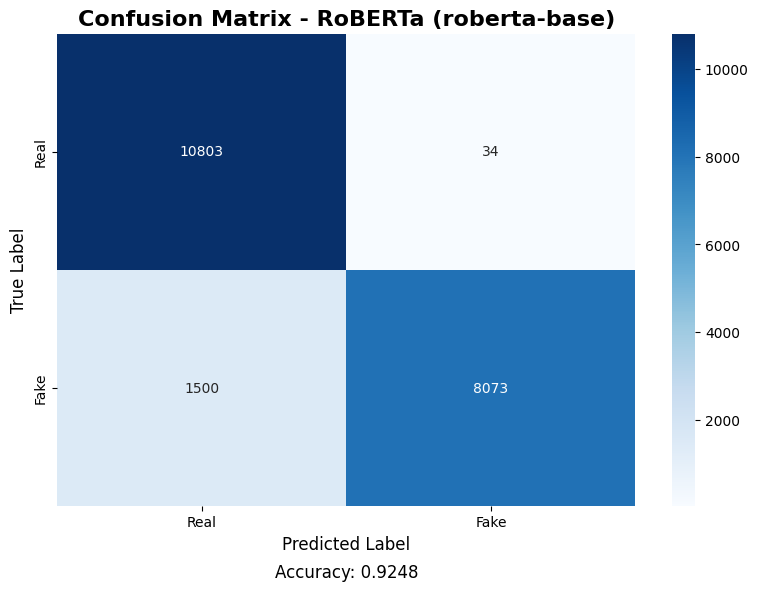

   ✅ Saved: /content/Fake_News_Detection_BERT/results/visualizations/roberta/confusion_matrix.png

📊 Creating ROC curve...


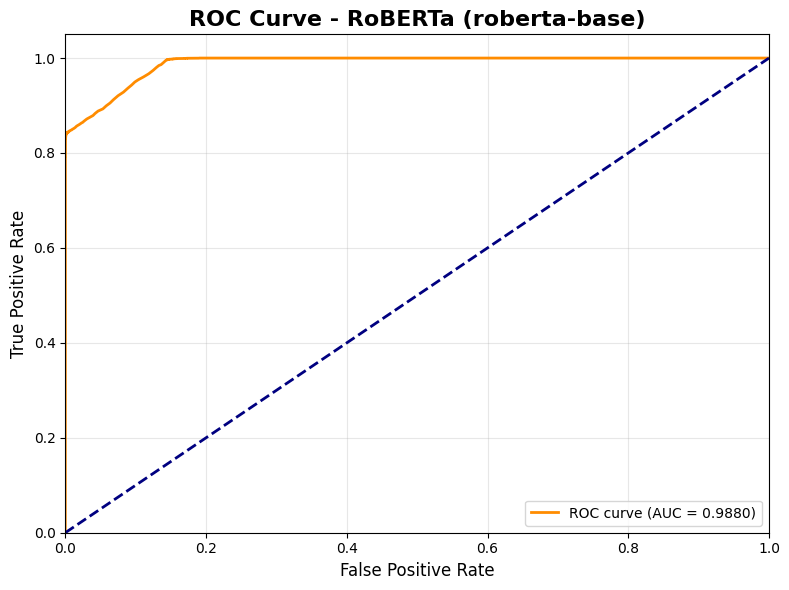

   ✅ Saved: /content/Fake_News_Detection_BERT/results/visualizations/roberta/roc_curve.png

✅ All visualizations created!


In [13]:
# CELL 11: Create Visualizations
# ============================================================================
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Create visualization directory
viz_dir = VISUALIZATIONS_DIR / 'roberta'
viz_dir.mkdir(parents=True, exist_ok=True)

try:
    # Confusion Matrix
    print("\n📊 Creating confusion matrix...")
    plot_confusion_matrix(
        y_true=y_test_true,
        y_pred=y_test_pred,
        model_name=f"RoBERTa ({ModelConfig.MODEL_NAME})",
        save_path=viz_dir / "confusion_matrix.png"
    )
    print(f"   ✅ Saved: {viz_dir / 'confusion_matrix.png'}")

    # ROC Curve
    print("\n📊 Creating ROC curve...")
    plot_roc_curve(
        y_true=y_test_true,
        y_proba=y_test_proba,
        model_name=f"RoBERTa ({ModelConfig.MODEL_NAME})",
        save_path=viz_dir / "roc_curve.png"
    )
    print(f"   ✅ Saved: {viz_dir / 'roc_curve.png'}")

    print("\n✅ All visualizations created!")

except Exception as e:
    print(f"❌ Visualization failed: {e}")
    # Continue even if visualization fails


MODEL COMPARISON
✅ Baseline results loaded

📊 Creating comparison visualization...


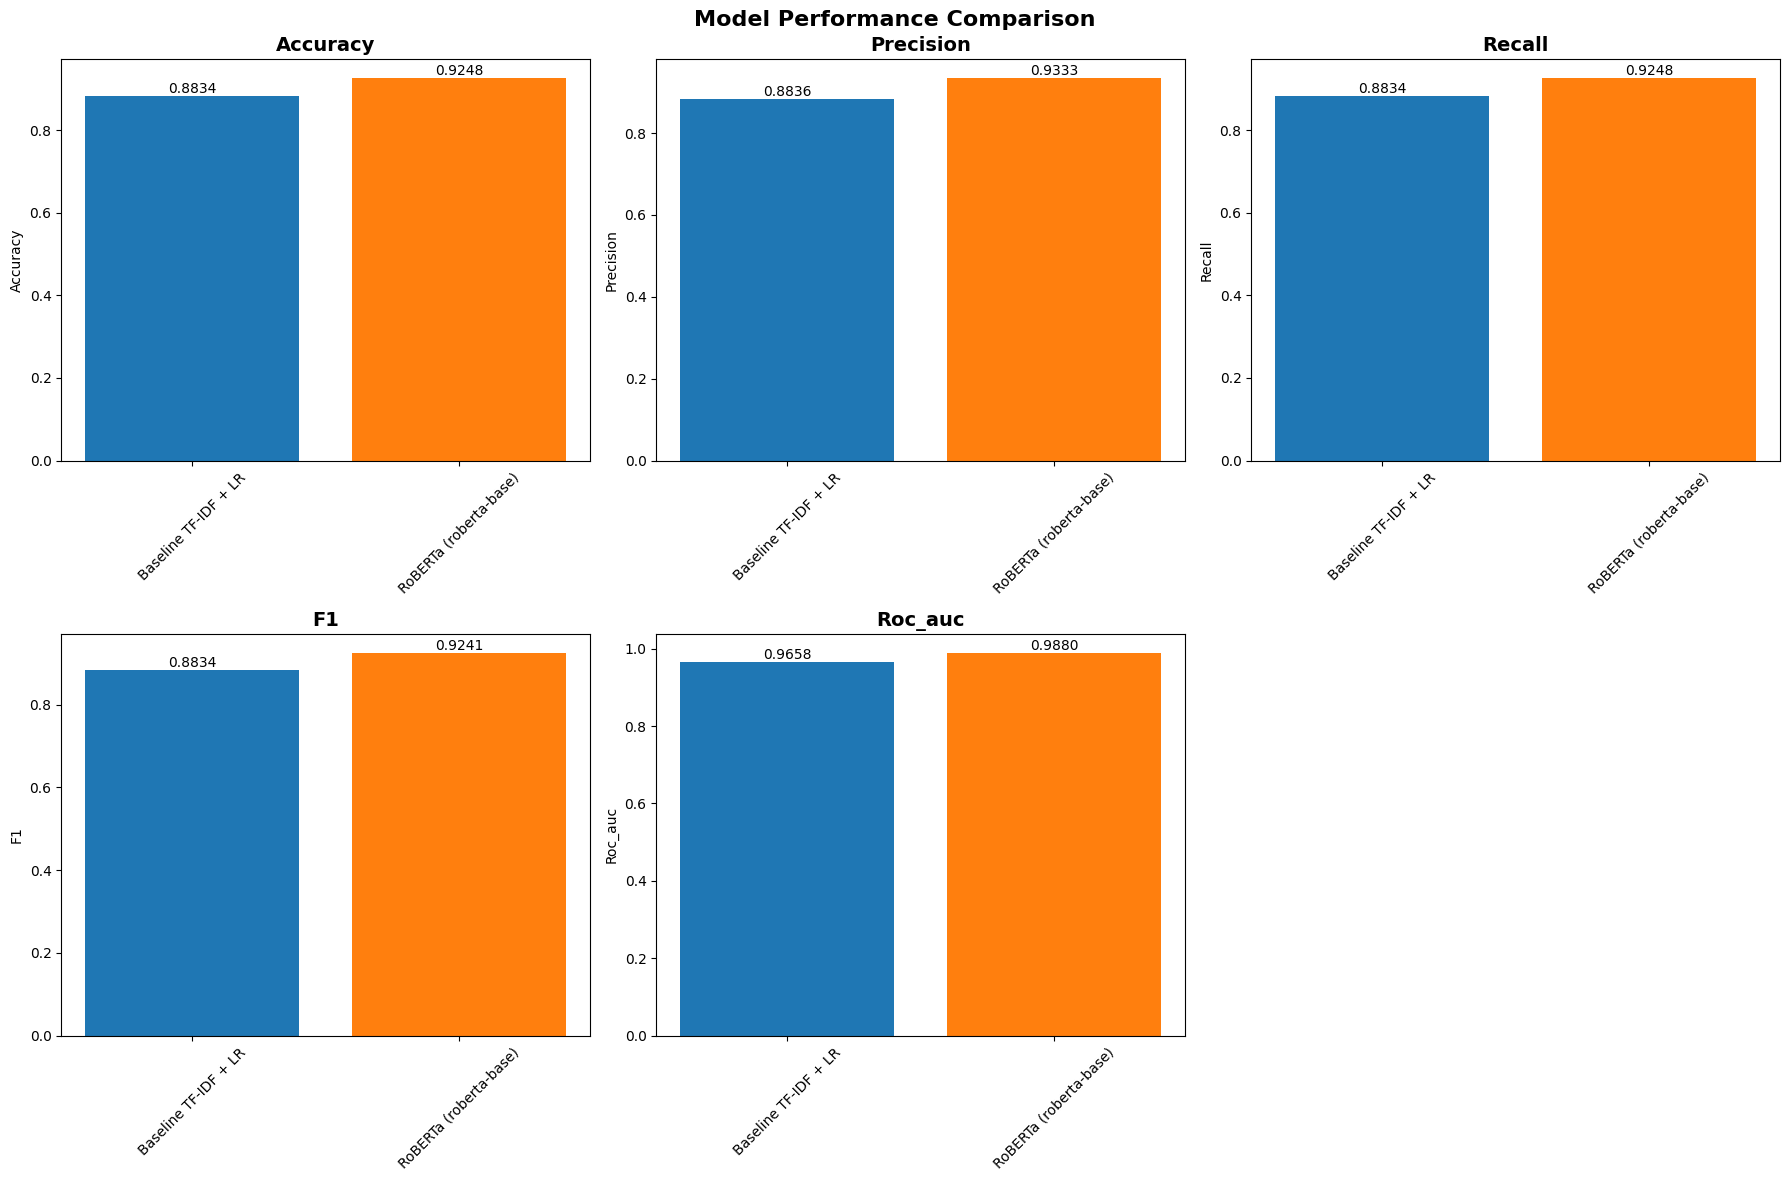


MODEL PERFORMANCE COMPARISON
                 Model  accuracy  precision  recall     f1  roc_auc
  Baseline TF-IDF + LR    0.8834     0.8836  0.8834 0.8834   0.9658
RoBERTa (roberta-base)    0.9248     0.9333  0.9248 0.9241   0.9880

🚀 Performance Improvements (RoBERTa vs Baseline):
   Accuracy       : 0.8834 → 0.9248 (+0.0415, +4.69%)
   Precision      : 0.8836 → 0.9333 (+0.0497, +5.63%)
   Recall         : 0.8834 → 0.9248 (+0.0415, +4.69%)
   F1             : 0.8834 → 0.9241 (+0.0407, +4.60%)
   Roc_auc        : 0.9658 → 0.9880 (+0.0222, +2.30%)


In [14]:
# CELL 12: Compare with Baseline
# ============================================================================
print("="*80)
print("MODEL COMPARISON")
print("="*80)

import json

try:
    # Try to load baseline results
    baseline_path = METRICS_DIR / "baseline_evaluation_results.json"

    if baseline_path.exists():
        with open(baseline_path, 'r') as f:
            baseline_evaluation = json.load(f)

        print("✅ Baseline results loaded")

        # Compare models
        print("\n📊 Creating comparison visualization...")
        comparison_df = compare_models(
            [baseline_evaluation, roberta_evaluation],
            save_path=viz_dir / "model_comparison.png"
        )

        # Calculate improvements
        metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']
        if 'roc_auc' in baseline_evaluation and 'roc_auc' in roberta_evaluation:
            metrics_to_compare.append('roc_auc')

        print(f"\n🚀 Performance Improvements (RoBERTa vs Baseline):")
        for metric in metrics_to_compare:
            if metric in baseline_evaluation and metric in roberta_evaluation:
                baseline_val = baseline_evaluation[metric]
                roberta_val = roberta_evaluation[metric]
                improvement = roberta_val - baseline_val
                pct_improvement = (improvement / baseline_val) * 100 if baseline_val > 0 else 0

                print(f"   {metric.capitalize():15}: {baseline_val:.4f} → {roberta_val:.4f} "
                      f"(+{improvement:.4f}, +{pct_improvement:.2f}%)")

    else:
        print("⚠️  Baseline results not found")
        print(f"   Looking for: {baseline_path}")
        print("   Skipping comparison")
        comparison_df = None

except Exception as e:
    print(f"⚠️  Comparison failed: {e}")
    comparison_df = None

In [22]:
# CELL 13: Save Final Model for Deployment (Google Drive version)
# ============================================================================
from google.colab import drive
import shutil
from pathlib import Path

print("="*80)
print("SAVING FINAL MODEL FOR DEPLOYMENT TO GOOGLE DRIVE")
print("="*80)

try:
    # Mount Google Drive
    drive.mount('/content/drive')

    # 1. Save only the final model (no intermediate checkpoints)
    final_model_dir = Path(output_dir)  # assuming output_dir points to final model folder
    # Hugging Face Trainer mặc định lưu final model tại output_dir khi training xong
    bert_trainer.save_model(final_model_dir)
    print(f"✅ Final model saved at: {final_model_dir}")

    # 2. Optionally, remove unnecessary files to reduce size
    # Keep only essential files: pytorch_model.bin, config.json, tokenizer files
    keep_files = ["pytorch_model.bin", "config.json", "tokenizer.json",
                  "vocab.txt", "special_tokens_map.json"]
    for f in final_model_dir.iterdir():
        if f.name not in keep_files:
            if f.is_file():
                f.unlink()
            elif f.is_dir():
                shutil.rmtree(f)

    # 3. Zip final model folder
    model_zip_path = "/content/roberta_final_model.zip"
    shutil.make_archive(base_name=model_zip_path.replace(".zip",""),
                        format="zip",
                        root_dir=str(final_model_dir))
    print(f"✅ Final model zipped at: {model_zip_path}")

    # 4. Copy zip into Google Drive
    drive_path = Path("/content/drive/MyDrive/roberta_final_model.zip")
    shutil.copy(model_zip_path, drive_path)
    print(f"✅ Final model zip copied to Google Drive at: {drive_path}")

    print("\n✅ Final model is ready for deployment from Google Drive!")

except Exception as e:
    print(f"❌ Failed to save final model: {e}")
    raise


SAVING FINAL MODEL FOR DEPLOYMENT TO GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ Failed to save final model: 'BertTrainer' object has no attribute 'state'


AttributeError: 'BertTrainer' object has no attribute 'state'

In [16]:
# CELL 14: Final Summary
# ============================================================================
print("\n" + "="*80)
print("🎉 ROBERTA MODEL TRAINING COMPLETE!")
print("="*80)

print("\n✅ Completed Tasks:")
print("   ✓ Loaded and prepared data")
print("   ✓ Created PyTorch datasets")
print("   ✓ Fine-tuned RoBERTa model")
print("   ✓ Evaluated on test set")
print("   ✓ Generated predictions")
print("   ✓ Computed extended metrics")
print("   ✓ Created visualizations")
if comparison_df is not None:
    print("   ✓ Compared with baseline")
print("   ✓ Saved all results")

print(f"\n📊 Final Model Performance:")
print(f"   Model:     {ModelConfig.MODEL_NAME}")
print(f"   Device:    {device}")
print(f"   Accuracy:  {roberta_evaluation['accuracy']:.4f}")
print(f"   Precision: {roberta_evaluation['precision']:.4f}")
print(f"   Recall:    {roberta_evaluation['recall']:.4f}")
print(f"   F1-score:  {roberta_evaluation['f1']:.4f}")
if 'roc_auc' in roberta_evaluation:
    print(f"   ROC-AUC:   {roberta_evaluation['roc_auc']:.4f}")
print(f"   Training:  {train_results['training_time']:.2f}s")

print(f"\n📁 Output Locations:")
print(f"   Model:         {output_dir}")
print(f"   Metrics:       {metrics_dir}")
print(f"   Visualizations: {viz_dir}")

if comparison_df is not None:
    print(f"\n🚀 Best Performance Gains:")
    for metric in ['accuracy', 'f1']:
        if metric in roberta_evaluation and metric in baseline_evaluation:
            improvement = roberta_evaluation[metric] - baseline_evaluation[metric]
            print(f"   {metric.capitalize()}: +{improvement:.4f} (+{improvement*100:.2f}%)")

print("\n🎯 Next Steps:")
print("   → Deploy model to production")
print("   → Build FastAPI endpoint")
print("   → Create frontend interface")
print("   → Monitor model performance")

print("\n" + "="*80)
print("🎊 PROJECT READY FOR DEPLOYMENT!")
print("="*80)


🎉 ROBERTA MODEL TRAINING COMPLETE!

✅ Completed Tasks:
   ✓ Loaded and prepared data
   ✓ Created PyTorch datasets
   ✓ Fine-tuned RoBERTa model
   ✓ Evaluated on test set
   ✓ Generated predictions
   ✓ Computed extended metrics
   ✓ Created visualizations
   ✓ Compared with baseline
   ✓ Saved all results

📊 Final Model Performance:
   Model:     roberta-base
   Device:    cuda
   Accuracy:  0.9248
   Precision: 0.9333
   Recall:    0.9248
   F1-score:  0.9241
   ROC-AUC:   0.9880
   Training:  4042.57s

📁 Output Locations:
   Model:         /content/Fake_News_Detection_BERT/models/roberta
   Metrics:       /content/Fake_News_Detection_BERT/results/metrics/roberta
   Visualizations: /content/Fake_News_Detection_BERT/results/visualizations/roberta

🚀 Best Performance Gains:
   Accuracy: +0.0415 (+4.15%)
   F1: +0.0407 (+4.07%)

🎯 Next Steps:
   → Deploy model to production
   → Build FastAPI endpoint
   → Create frontend interface
   → Monitor model performance

🎊 PROJECT READY FOR D

📤 Upload file CSV của bạn...


Saving Book1.xlsx to Book1.xlsx
📄 File type: xlsx


2025-11-06 03:38:43 - preprocessing - INFO - TextPreprocessor initialized
INFO:preprocessing:TextPreprocessor initialized
2025-11-06 03:38:43 - preprocessing - INFO -   - Remove URLs: True
INFO:preprocessing:  - Remove URLs: True
2025-11-06 03:38:43 - preprocessing - INFO -   - Remove Mentions: True
INFO:preprocessing:  - Remove Mentions: True
2025-11-06 03:38:43 - preprocessing - INFO -   - Remove Hashtags: True
INFO:preprocessing:  - Remove Hashtags: True
2025-11-06 03:38:43 - preprocessing - INFO -   - Lowercase: True
INFO:preprocessing:  - Lowercase: True


✅ Loaded Excel file
✅ Loaded: 199 rows
📊 Columns: ['Content', 'Label']
✅ Using column: 'Content'

🔄 Preprocessing 199 texts...
✅ Using TextPreprocessor from src.preprocessing
✅ Preprocessing done: 199 texts ready

📥 Loading model...
✅ Model loaded on cuda

🔮 Predicting 199 samples...
Processed 199/199
✅ Done!

📊 Results:
   Total: 199
   REAL:  61 (30.7%)
   FAKE:  138 (69.3%)
   Avg confidence: 98.59%

✅ Found ground truth labels: 'Label'
📊 Computing metrics and visualizations...


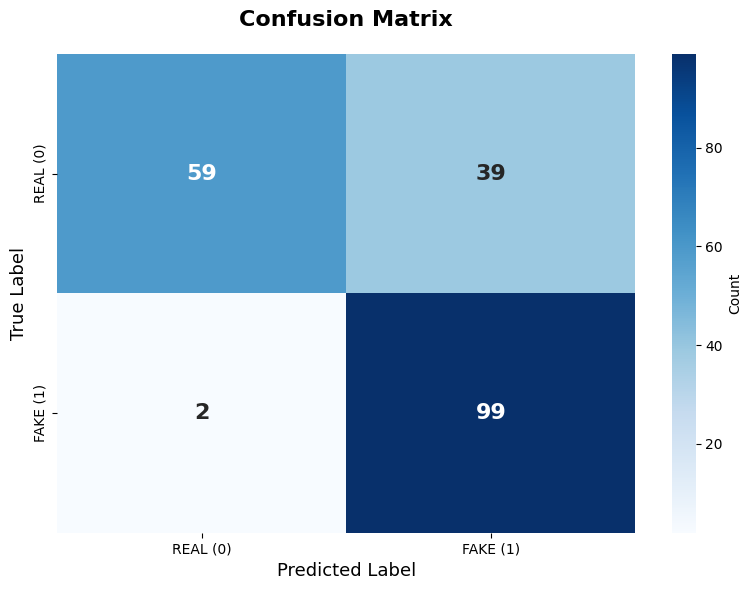


📊 PERFORMANCE METRICS

🎯 Overall Metrics:
   Accuracy:  0.7940 (79.40%)
   Precision: 0.8404
   Recall:    0.7940
   F1-Score:  0.7859

📋 Per-Class Metrics:

   Class REAL (0):
      Precision: 0.9672
      Recall:    0.6020
      F1-Score:  0.7421

   Class FAKE (1):
      Precision: 0.7174
      Recall:    0.9802
      F1-Score:  0.8285

🔍 Confusion Matrix Breakdown:
   True Positives (TP):     99  (Correctly predicted FAKE)
   True Negatives (TN):     59  (Correctly predicted REAL)
   False Positives (FP):    39  (REAL predicted as FAKE)
   False Negatives (FN):     2  (FAKE predicted as REAL)

💾 Saving to predictions.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📋 Sample results:
  predicted_label  confidence
0            FAKE    0.999874
1            FAKE    0.999811
2            FAKE    0.999677
3            FAKE    0.999702
4            FAKE    0.999915
5            FAKE    0.999779
6            FAKE    0.999740
7            FAKE    0.999874
8            FAKE    0.999830
9            REAL    0.992698


In [17]:
"""
Upload CSV và test model RoBERTa đã train
Tự động preprocess data thực tế trước khi predict
"""

import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Import preprocessing từ src
try:
    from src.preprocessing import TextPreprocessor
    from src.config import DataConfig
    PREPROCESSING_AVAILABLE = True
except ImportError:
    print("⚠️  Warning: src.preprocessing not found, using basic cleaning")
    PREPROCESSING_AVAILABLE = False

# ============================================================================
# TEXT PREPROCESSING (Basic fallback nếu không có src.preprocessing)
# ============================================================================

def basic_clean_text(text):
    """Basic text cleaning nếu không có TextPreprocessor"""
    import re

    if pd.isna(text):
        return ""

    text = str(text)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.[a-zA-Z0-9-]+\.[a-zA-Z]{2,}', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Strip and lowercase
    text = text.strip().lower()

    return text


def preprocess_dataframe(df, text_column):
    """
    Preprocess DataFrame với text cleaning

    Args:
        df: DataFrame
        text_column: Tên cột chứa text

    Returns:
        DataFrame với cột 'cleaned_content'
    """
    print(f"\n🔄 Preprocessing {len(df)} texts...")

    if PREPROCESSING_AVAILABLE:
        # Sử dụng TextPreprocessor từ src
        try:
            preprocessor = TextPreprocessor(
                remove_urls=DataConfig.REMOVE_URLS,
                remove_mentions=DataConfig.REMOVE_MENTIONS,
                remove_hashtags=DataConfig.REMOVE_HASHTAGS,
                lowercase=DataConfig.LOWERCASE,
                remove_extra_spaces=DataConfig.REMOVE_EXTRA_SPACES
            )
            df['cleaned_content'] = df[text_column].apply(preprocessor.clean_text)
            print("✅ Using TextPreprocessor from src.preprocessing")
        except Exception as e:
            print(f"⚠️  TextPreprocessor failed: {e}")
            print("   Using basic cleaning...")
            df['cleaned_content'] = df[text_column].apply(basic_clean_text)
    else:
        # Fallback: basic cleaning
        df['cleaned_content'] = df[text_column].apply(basic_clean_text)
        print("✅ Using basic text cleaning")

    # Remove empty texts
    initial_len = len(df)
    df = df[df['cleaned_content'].str.len() > 0].reset_index(drop=True)
    removed = initial_len - len(df)

    if removed > 0:
        print(f"⚠️  Removed {removed} empty texts after cleaning")

    print(f"✅ Preprocessing done: {len(df)} texts ready")

    return df


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_results(df, true_label_col='label'):
    """
    Visualize predictions với confusion matrix và metrics

    Args:
        df: DataFrame với cột 'prediction' và true label
        true_label_col: Tên cột chứa ground truth labels
    """

    # Lấy true labels và predictions
    y_true = df[true_label_col].values
    y_pred = df['prediction'].values
    y_proba = df['prob_fake'].values  # Probability của class FAKE

    # Tạo figure với 1 subplot cho confusion matrix
    plt.figure(figsize=(8, 6))

    # ========================================================================
    # CONFUSION MATRIX
    # ========================================================================
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['REAL (0)', 'FAKE (1)'],
                yticklabels=['REAL (0)', 'FAKE (1)'],
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 16, 'weight': 'bold'})

    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=13)
    plt.xlabel('Predicted Label', fontsize=13)

    plt.tight_layout()
    plt.show()

    # ========================================================================
    # PRINT DETAILED METRICS
    # ========================================================================
    print("\n" + "="*80)
    print("📊 PERFORMANCE METRICS")
    print("="*80)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n🎯 Overall Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    # Per-class metrics
    print(f"\n📋 Per-Class Metrics:")
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    print(f"\n   Class REAL (0):")
    print(f"      Precision: {precision_per_class[0]:.4f}")
    print(f"      Recall:    {recall_per_class[0]:.4f}")
    print(f"      F1-Score:  {f1_per_class[0]:.4f}")

    print(f"\n   Class FAKE (1):")
    print(f"      Precision: {precision_per_class[1]:.4f}")
    print(f"      Recall:    {recall_per_class[1]:.4f}")
    print(f"      F1-Score:  {f1_per_class[1]:.4f}")

    # Confusion matrix breakdown
    print(f"\n🔍 Confusion Matrix Breakdown:")
    tn, fp, fn, tp = cm.ravel()
    print(f"   True Positives (TP):  {tp:5d}  (Correctly predicted FAKE)")
    print(f"   True Negatives (TN):  {tn:5d}  (Correctly predicted REAL)")
    print(f"   False Positives (FP): {fp:5d}  (REAL predicted as FAKE)")
    print(f"   False Negatives (FN): {fn:5d}  (FAKE predicted as REAL)")

    print("="*80)


# ============================================================================
# UPLOAD & PREDICT
# ============================================================================

def predict_from_csv(model_path="/content/Fake_News_Detection_BERT/models/roberta"):
    """
    Upload CSV file và predict

    Usage:
        df_results = predict_from_csv()
    """

    # 1. Upload CSV
    print("📤 Upload file CSV của bạn...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ Không có file được upload!")
        return None

    filename = list(uploaded.keys())[0]
    file_ext = filename.split('.')[-1].lower()

    print(f"📄 File type: {file_ext}")

    # Đọc file dựa vào extension
    df = None

    try:
        if file_ext in ['xlsx', 'xls']:
            # Excel file
            df = pd.read_excel(io.BytesIO(uploaded[filename]))
            print(f"✅ Loaded Excel file")
        elif file_ext == 'csv':
            # CSV file - thử nhiều encoding
            encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
            for encoding in encodings:
                try:
                    df = pd.read_csv(
                        io.BytesIO(uploaded[filename]),
                        encoding=encoding,
                        on_bad_lines='skip',
                        engine='python'
                    )
                    print(f"✅ Loaded CSV with encoding: {encoding}")
                    break
                except:
                    continue
        else:
            print(f"❌ Unsupported file type: {file_ext}")
            print("💡 Supported: .csv, .xlsx, .xls")
            return None

    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    if df is None:
        print("❌ Could not read file!")
        return None

    print(f"✅ Loaded: {len(df)} rows")
    print(f"📊 Columns: {df.columns.tolist()}")

    # 2. Tìm cột text
    text_col = None
    possible_cols = ['content', 'text', 'cleaned_content', 'article', 'news', 'title', 'Content']
    for col in possible_cols:
        if col in df.columns:
            text_col = col
            break

    if text_col is None:
        print(f"❌ Không tìm thấy cột text!")
        print(f"Cần có 1 trong các cột: {possible_cols}")
        return None

    print(f"✅ Using column: '{text_col}'")

    # 3. Preprocess texts (CLEAN DATA)
    df = preprocess_dataframe(df, text_col)

    # 4. Load model
    print(f"\n📥 Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    print(f"✅ Model loaded on {device}")

    # 5. Predict với cleaned text
    print(f"\n🔮 Predicting {len(df)} samples...")

    texts = df[text_col].fillna("").astype(str).tolist()

    all_predictions = []
    all_probs = []

    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Tokenize
        inputs = tokenizer(
            batch,
            truncation=True,
            padding='max_length',
            max_length=256,
            return_tensors='pt'
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)}", end='\r')

    print(f"\n✅ Done!")

    # 6. Add results to dataframe (GIỮ CẢ RAW VÀ CLEANED TEXT)
    df['prediction'] = all_predictions
    df['predicted_label'] = df['prediction'].map({0: 'REAL', 1: 'FAKE'})
    df['confidence'] = [max(p) for p in all_probs]
    df['prob_real'] = [p[0] for p in all_probs]
    df['prob_fake'] = [p[1] for p in all_probs]

    # 6. Statistics
    print(f"\n📊 Results:")
    print(f"   Total: {len(df)}")
    print(f"   REAL:  {(df['prediction']==0).sum()} ({(df['prediction']==0).sum()/len(df)*100:.1f}%)")
    print(f"   FAKE:  {(df['prediction']==1).sum()} ({(df['prediction']==1).sum()/len(df)*100:.1f}%)")
    print(f"   Avg confidence: {df['confidence'].mean():.2%}")

    # 8. Visualize if ground truth available
    # Tìm cột label gốc (true labels)
    true_label_col = None
    possible_label_cols = ['label', 'Label', 'true_label', 'actual_label', 'ground_truth', 'target']

    for col in possible_label_cols:
        if col in df.columns and col != 'predicted_label':
            true_label_col = col
            break

    if true_label_col:
        print(f"\n✅ Found ground truth labels: '{true_label_col}'")
        print(f"📊 Computing metrics and visualizations...")
        visualize_results(df, true_label_col)
    else:
        print(f"\n⚠️  No ground truth labels found.")
        print(f"   To see metrics, CSV file should have column: 'label' or 'true_label'")

    # 9. Save & download
    output_file = "predictions.csv"
    df.to_csv(output_file, index=False)
    print(f"\n💾 Saving to {output_file}...")
    files.download(output_file)

    return df


# ============================================================================
# RUN
# ============================================================================

# Chạy function này
df_results = predict_from_csv()

# Xem kết quả
if df_results is not None:
    print("\n📋 Sample results:")
    display_cols = ['predicted_label', 'confidence']
    if len(df_results.columns) > 10:
        # Show first few columns + prediction columns
        display_cols = df_results.columns[:3].tolist() + ['predicted_label', 'confidence']
    print(df_results[display_cols].head(10))